# Bare Bones Neural Net

Continuation of zero_to_neural_net.ipynb

Implements some new techniques:
- vectorization of layers
- xavier weight initialization
- fixed normalization from last notebooks
- adam optimizer
- learning rate decay

Next steps:
- forgo generating a training set of discrete points and instead directly get values from julia_set function using random floats, 
- possibly use a framework for ease of use and performance (or rewrite everything in numba)
- hyperparameter sweeps (needs optimized first)


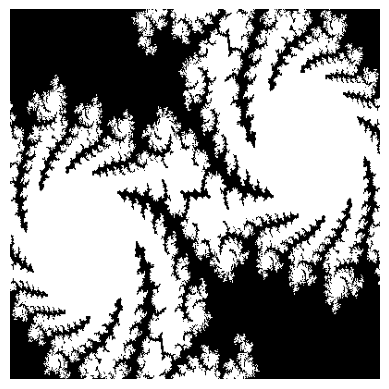

In [ ]:
# generate training data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#stolen from stack overflow
def julia_set(w=1000, h=1000, zoom=1.5, cX=-0.7, cY=0.27015, moveX=0.0, moveY=0.0, maxIter=150):
    arr = np.zeros((h, w), dtype=np.int16)

    for x in range(w):
        for y in range(h):
            zx = 1.5 * (x - w / 2) / (0.5 * zoom * w) + moveX
            zy = 1.0 * (y - h / 2) / (0.5 * zoom * h) + moveY
            i = maxIter
            while zx * zx + zy * zy < 4 and i > 1:
                tmp = zx * zx - zy * zy + cX
                zy, zx = 2.0 * zx * zy + cY, tmp
                i -= 1
            arr[y, x] = 1 if i == 1 else 0

    return arr


julia_set_train = julia_set(400, 400, zoom=2,maxIter=100)
plt.imshow(julia_set_train, cmap="gray")
plt.axis("off")
plt.show()


coordinates = []
for i,row in enumerate(julia_set_train):
    for j,pixel in enumerate(julia_set_train[i]):
        coordinates.append([i,j])

#keep track of x and y input
coordinates = np.array(coordinates)
coordinates = np.stack(coordinates,axis=-1)

#keep track of output of x and y
labels = julia_set_train.flatten()

In [ ]:
def relu_derivative(input):
    return np.array(input >0).astype(float)
def relu_function(input):
    return np.maximum(input,0)
def leaky_relu_function(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)
def leaky_relu_derivative(x, alpha=0.1):
    return np.where(x > 0, 1, alpha)
def tanh_derivative(x):
    return 1 - np.tanh(x)**2
def tanh_function(x):
    return np.tanh(x)
def sigmoid_function(x):
    return 1 / ( 1 + np.exp(-x))
def sigmoid_derivative(x):
    sigmoid = 1 / ( 1 + np.exp(-x))
    return sigmoid * (1 - sigmoid)

def bce_function(y_true, y_predicted):
    epsilon=1e-7
    y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)  
    loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
    return loss
def bce_grad(y_true, y_predicted):
    epsilon = 1e-7
    y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)
    grad = (y_predicted - y_true) / len(y_true)
    return grad


class Layer:
    def __init__(self,num_inputs,num_outputs,activation,activation_derivative):
        self.W = (np.random.rand(num_outputs,num_inputs) * 2 )- 1  
        self.b = np.zeros((num_outputs,1))
        self.activation = activation
        self.activation_derivative = activation_derivative

        self.Sdw = 0 
        self.Sdb = 0
        self.Vdw = 0
        self.Vdb = 0

        self.enable_adam = True
        self.i=0 #iteration tracker
        self.beta_1 = 0.9 # Momentum beta
        self.beta_2 = 0.999 # RMSProp beta
    def forward(self,prev_a):
        self.prev_a = prev_a
        # linear transformation 
        self.z = self.W @ prev_a + self.b
        # activation
        self.a = self.activation(self.z)
        return self.a

    def backward(self,da):
        # find dz using da received from layer+1 dJ/dz = dJ/da * da/dz
        # da/dz = dJ/da * activation derivative
        dz = da * self.activation_derivative(self.z)
        batch_size = self.prev_a.shape[1]

        #find dw: dz @ prev_a.T: (num_outputs, batch_size) @ (batch_size, num_inputs) = (num_outputs, num_inputs)
        # divide by batch size to get average over our batch
        self.dw = (dz @ self.prev_a.T) / batch_size
        #find db: similar to dw
        #use mean to find average gradient of each bias over our many batches
        self.db = np.sum(dz, axis=1, keepdims=True) / batch_size # (8, 1)
        #find prev_da to send to layer-1
        #W.T @ dz: (num_inputs, num_outputs) @ (num_outputs, batch_size) = (num_inputs, batch_size)
        prev_da = self.W.T @ dz  
        return prev_da

    def tune(self,learning_rate):
        #update weights and biases with gradient after back prop

        if not self.enable_adam:
            self.W -= learning_rate * self.dw
            self.b -= learning_rate * self.db
        else:
            # Adam optimizer
            self.i+= 1
            i = self.i
            epsilon = 1e-8 # numerical stability for if gradient is very small, doesn't affect performance 

            # RMSprop 
            self.Sdw = self.beta_2 * self.Sdw + (1 - self.beta_2) * (self.dw**2)
            self.Sdb = self.beta_2 * self.Sdb + (1 - self.beta_2) * (self.db**2)
            
            # Momentum 
            self.Vdw = self.beta_1 * self.Vdw + (1 - self.beta_1) * self.dw
            self.Vdb = self.beta_1 * self.Vdb + (1 - self.beta_1) * self.db
            
            #RMSprop bias correction
            Vdw_corrected = self.Vdw / (1 - self.beta_1**i)
            Vdb_corrected = self.Vdb / (1 - self.beta_1**i)

            #Momentum bias correction
            Sdw_corrected = self.Sdw / (1 - self.beta_2**i)
            Sdb_corrected = self.Sdb / (1 - self.beta_2**i)
            
            # Adam update
            self.W -= learning_rate * (Vdw_corrected / (np.sqrt(Sdw_corrected) + epsilon))
            self.b -= learning_rate * (Vdb_corrected / (np.sqrt(Sdb_corrected) + epsilon))



class MLP:
    def __init__(self,layers:list[Layer],loss_fun,loss_grad,weight_decay = None):
        self.loss_fun = loss_fun
        self.loss_grad = loss_grad
        self.layers:list[Layer] = layers
        #had worse results these initializations, gonna stick with [-1,1] distribution
        # init_type = "xavier"
        init_type = ""

        for l,layer in enumerate(self.layers):
            #he initialization : relu activation
            if init_type == "he":
                n = layer.W.shape[1]
                layer.W = np.random.randn(*layer.W.shape) * np.sqrt(2/n)

            # xavier initialization: tanh activation
            if init_type == "xavier":
                n = layer.W.shape[1]  # fan_in
                limit = np.sqrt(6 / n)
                layer.W = np.random.uniform(-limit, limit, size=layer.W.shape)

    def forward(self,activations,y_true):
        self.y_true = y_true
        self.activations = activations
        #forward pass of all layers
        for layer in self.layers:
            self.activations = layer.forward(self.activations)
        # compute loss
        self.loss = self.loss_fun(y_true,self.activations)
        

    def backward(self):
        #find gradient of our loss function
        j_wrt_a = self.loss_grad(self.y_true,self.activations)
        #send back through to each layer to update dW and db for each layer
        for layer in reversed(self.layers):
            j_wrt_a = layer.backward(j_wrt_a)
    
    def tune(self,learning_rate):
        for layer in self.layers:
            layer.tune(learning_rate)




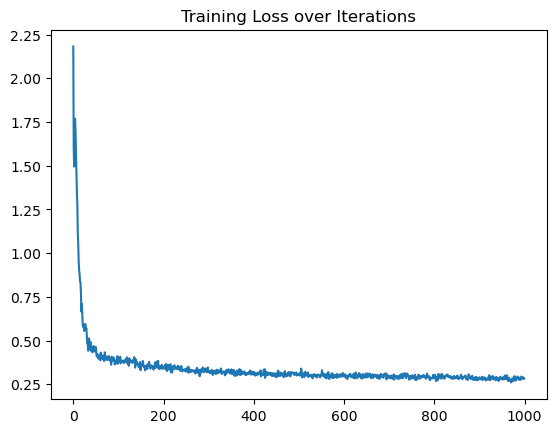

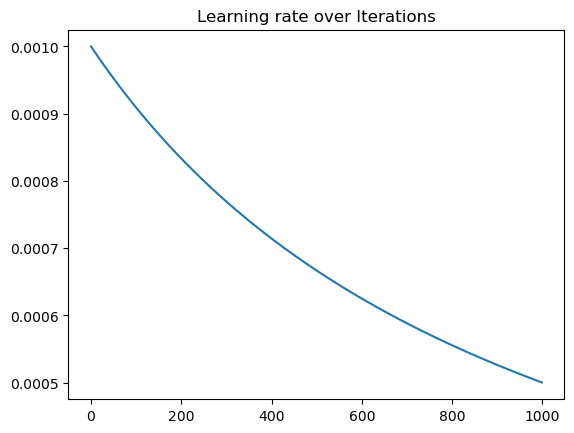

In [ ]:
y = labels 
X = coordinates

#normilization
mean = np.mean(coordinates)
X = X - mean 
variance_squared = np.mean(X**2)
X = X / variance_squared

layers = [
    Layer(2,256,tanh_function,tanh_derivative),
    Layer(256,256,tanh_function,tanh_derivative),
    Layer(256,256,tanh_function,tanh_derivative),
    Layer(256,256,tanh_function,tanh_derivative),
    Layer(256,256,tanh_function,tanh_derivative),
    Layer(256,1,sigmoid_function, sigmoid_derivative),
]

num_iterations = 1000
batch_size = 4000
learning_rate = 0.001
learning_rate_decay = 0.001

loss_time = []
learning_rate_time =[]
mlp = MLP(layers,loss_fun = bce_function , loss_grad=bce_grad )

for i in range(num_iterations):

    # lazy mini-batching
    sample_index = np.random.choice(len(y), size=batch_size, replace=False)
    X_batch = X[:, sample_index]
    y_batch = y[sample_index]
    y_batch = np.reshape(y_batch,(1,-1))

    loss = mlp.forward(
        activations= X_batch,
        y_true=y_batch)
    mlp.backward()

    lr = 1 / (1+learning_rate_decay * i) * learning_rate
    if learning_rate_decay is not None:
        mlp.tune(lr)
    else:
        mlp.tune(learning_rate)

    # print(f"{loss=},{acc=} at {i}")
    # print(f"{loss=} at {i} learning rate: {lr}")
    loss_time.append(loss)
    learning_rate_time.append(lr)
plt.plot(loss_time)
plt.title("Training Loss over Iterations")
plt.show()


plt.plot(learning_rate_time)
plt.title("Learning rate over Iterations")
plt.show()

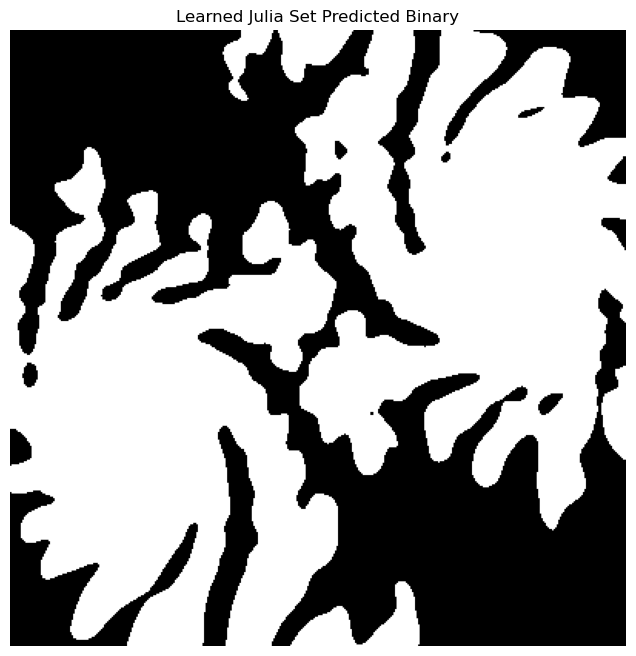

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

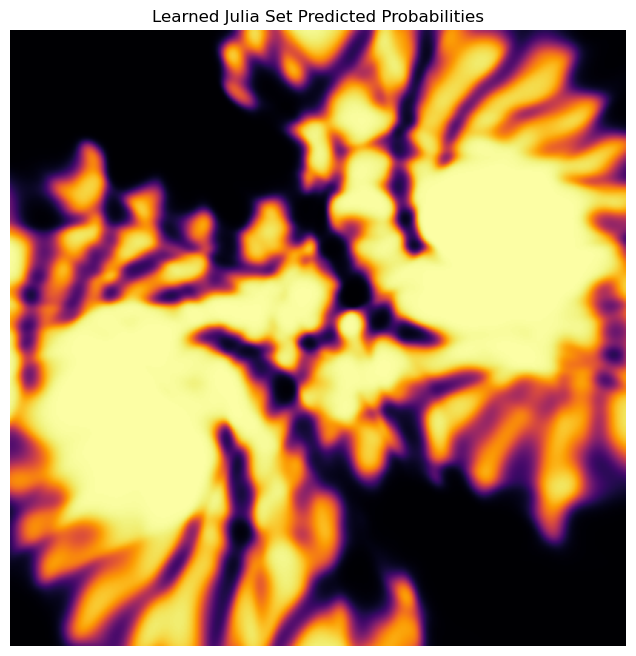

In [12]:
mlp.forward(
    activations=X,  # shape (2, N)
    y_true=y# not used except for loss calc
)

predicted = mlp.activations
predicted_image = predicted.reshape(julia_set_train.shape)

plt.figure(figsize=(8, 8))
plt.title("Learned Julia Set Predicted Binary")
plt.imshow((predicted_image > 0.5), cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.title("Learned Julia Set Predicted Probabilities")
plt.imshow(predicted_image, cmap='inferno')
plt.axis('off')